# Week 4.
**Deliverables**
* Refine prompts for Binary & Multitype

## 1. Prompt Library
Binary and multitype templates that feed every evaluation routine.


In [1]:
# BINARY PROMPTS
# (1) Zero-Shot — final (no inline JSON examples)
prompt_binary_zeroshot = """
You are analyzing whether a sentence describes Intimate Partner Violence (IPV).

Definition:
Intimate Partner Violence includes any form of physical, emotional, or sexual harm
inflicted by a partner. This may involve control, manipulation, threats, humiliation,
or physical aggression.

Decide if the following sentence involves IPV or not.

Sentence: "{text}"

Return ONLY one JSON object, enclosed between <json> and </json>.
Format: a single key "label" with value "IPV" or "NOT_IPV".
Print nothing else.
""".strip()


# (2) Few-Shot — final (no inline JSON examples)
prompt_binary_fewshot = """
You are classifying sentences as describing Intimate Partner Violence (IPV) or NOT_IPV.

Definition:
IPV occurs when one partner harms or controls another physically, emotionally, or sexually.

Here are examples (for guidance only):
1. "He pushed me against the wall and shouted that I’m worthless." → IPV
2. "She often insults me and forbids me from seeing my friends." → IPV
3. "We argued but both apologized and moved on peacefully." → NOT_IPV
4. "He surprised me with flowers after work." → NOT_IPV

Now analyze this sentence:
"{text}"

Return ONLY one JSON object, enclosed between <json> and </json>.
Format: {"label": "IPV"} or {"label": "NOT_IPV"}.
Print nothing else.
""".strip()


# (3) Chain-of-Thought — final (no inline JSON examples)
prompt_binary_cot = """
You are reasoning step-by-step to decide if a sentence describes Intimate Partner Violence (IPV).

Guidelines:
- IPV includes threats, coercion, physical harm, humiliation, or emotional manipulation.
- NOT_IPV describes healthy, neutral, or unrelated situations.

Think internally (do NOT show your reasoning) about:
1. Does the sentence show any behavior that causes harm, fear, or control?
2. Is there a partner/relationship context?
3. Does it express affection or support instead of harm?

After thinking silently, return ONLY one JSON object, enclosed between <json> and </json>.
Format: {"label": "IPV"} or {"label": "NOT_IPV"}.
Print nothing else.

Sentence: "{text}"
""".strip()


# (4) Meta — final (no inline JSON examples)
prompt_binary_meta = """
You are a social-behavioral analyst evaluating sentences for signs of Intimate Partner Violence (IPV).

Your objective is to be accurate but cautious.
- If the sentence clearly involves harm, coercion, or control → label as IPV.
- If the sentence shows affection, neutrality, or uncertainty → label as NOT_IPV.

Reflect internally before answering; do NOT print your reasoning.

Sentence: "{text}"

Return ONLY one JSON object, enclosed between <json> and </json>.
Format: {"label": "IPV"} or {"label": "NOT_IPV"}.
Print nothing else.
""".strip()


# (5) Self-Consistency — final (no inline JSON examples)
prompt_binary_selfconsistency = """
You will internally evaluate the sentence for Intimate Partner Violence (IPV) multiple times
and choose the majority label as your final answer.

Guidelines:
- IPV → signs of physical, emotional, or sexual harm, threats, or coercion.
- NOT_IPV → supportive, neutral, or unrelated content.

Do NOT reveal thoughts or votes.

Sentence: "{text}"

Return ONLY one JSON object, enclosed between <json> and </json>.
Format: {"label": "IPV"} or {"label": "NOT_IPV"}.
Print nothing else.
""".strip()

### 1.2 Multitype Prompts
These templates mirror the binary ones but collect subtype labels.


In [2]:
# MULTITYPE PROMPTS
prompt_multilabel_zeroshot = """
You are identifying which forms of Intimate Partner Violence (IPV) appear in a sentence.

Decide independently for emotional, physical, and sexual abuse.
Return ONLY one JSON object enclosed between <json> and </json> with the keys
'id', 'emotional', 'physical', and 'sexual'.

Sentence: "{text}"
Sample ID: "{sample_id}"
<json>
{{
  "id": "{sample_id}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}
</json>
""".strip()

prompt_multilabel_fewshot = """
You are labeling sentences for types of Intimate Partner Violence (IPV).
Use the examples to stay calibrated. For each category (emotional, physical, sexual), output 1 if it is clearly present, else 0.

Examples:
1. "He insults me daily and forbids me from leaving the house." -> emotional: 1, physical: 0, sexual: 0
2. "She slapped me when I disagreed with her." -> emotional: 0, physical: 1, sexual: 0
3. "They pressured me into intimacy when I said no." -> emotional: 0, physical: 0, sexual: 1
4. "We spent the evening cooking together peacefully." -> emotional: 0, physical: 0, sexual: 0

Sentence: "{text}"
Sample ID: "{sample_id}"
<json>
{{
  "id": "{sample_id}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}
</json>
""".strip()

prompt_multilabel_cot = """
Reason silently about whether emotional, physical, or sexual IPV occurs in the sentence.
Use relationship context, threats, coercion, and bodily harm cues.
After your hidden reasoning, output ONLY the JSON block specified below.

Sentence: "{text}"
Sample ID: "{sample_id}"
<json>
{{
  "id": "{sample_id}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}
</json>
""".strip()

prompt_multilabel_meta = """
Act as a cautious social-behavioral analyst.
Label a subtype as 1 only when the text clearly shows that form of IPV; otherwise return 0.
Favor precision to avoid false positives.

Sentence: "{text}"
Sample ID: "{sample_id}"
<json>
{{
  "id": "{sample_id}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}
</json>
""".strip()

prompt_multilabel_selfconsistency = """
Independently evaluate the sentence multiple times to reduce uncertainty.
After internal self-consistency voting, output the majority decision for each subtype in the JSON schema below.
Do not reveal the intermediate thoughts.

Sentence: "{text}"
Sample ID: "{sample_id}"
<json>
{{
  "id": "{sample_id}",
  "emotional": 0 or 1,
  "physical": 0 or 1,
  "sexual": 0 or 1
}}
</json>
""".strip()


## 2. System & Model Setup
Shared imports, paths, and model objects. Execute once per runtime.


In [18]:
from __future__ import annotations

import json
import math
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "Qwen/Qwen2.5-7B-Instruct"
DATASET_PATH = Path("../Dataset/reddut_data.csv")
RESULTS_ROOT = Path("test_results_raw")
BINARY_RESULTS_DIR = RESULTS_ROOT / "binary"
MULTITYPE_RESULTS_DIR = RESULTS_ROOT / "multitype"

print(f"Loading {MODEL_NAME} ...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model.eval()
print("Model ready.")


Loading Qwen/Qwen2.5-7B-Instruct ...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model ready.


## 3. Prediction Generation
Run the Colab cloning cell first, then load the dataset and choose either binary or multitype generation.


In [4]:
#Clone from git
!git clone https://github.com/zelaneroz/ipvresearch25
%cd ipvresearch25/1_LLM_Eval
#Load dataset
filename = "../Dataset/reddit_data.csv"
df = pd.read_csv(filename)

Cloning into 'ipvresearch25'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 225 (delta 110), reused 148 (delta 51), pack-reused 0 (from 0)
Receiving objects: 100% (225/225), 7.94 MiB | 39.07 MiB/s, done.
Resolving deltas: 100% (110/110), done.
/content/ipvresearch25/1_LLM_Eval


### 3.0 Data Access & Directories
Loads the dataset and prepares local folders for saving model outputs.


In [5]:
# Dataset + result folders
BINARY_RESULTS_DIR.mkdir(parents=True, exist_ok=True)
MULTITYPE_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# if not filename.exists():
#     raise FileNotFoundError(f"Dataset not found at {filename}. Run the git clone cell above or update DATASET_PATH.")

# df = pd.read_csv(filename)
# print(f"Loaded {len(df)} rows from {filename}")



In [6]:
# Prompt registries for downstream loops
binary_prompts = {
    "zeroshot": prompt_binary_zeroshot,
    "fewshot": prompt_binary_fewshot,
    "cot": prompt_binary_cot,
    "meta": prompt_binary_meta,
    "selfconsistency": prompt_binary_selfconsistency,
}

multilabel_prompts = {
    "zeroshot": prompt_multilabel_zeroshot,
    "fewshot": prompt_multilabel_fewshot,
    "cot": prompt_multilabel_cot,
    "meta": prompt_multilabel_meta,
    "selfconsistency": prompt_multilabel_selfconsistency,
}


### 3.1 Binary Prediction Generation

In [7]:
def test_binary_prompts(df: pd.DataFrame, path: Path, n_samples: int = 3) -> None:
    """Run all binary prompt types on the first `n_samples` rows and persist outputs."""
    import re

    df_subset = df.head(n_samples)
    results_dir = Path(path)
    results_dir.mkdir(parents=True, exist_ok=True)

    print("Running binary classification tests...")
    print(f"Number of samples: {len(df_subset)}")
    print(f"Results will be saved in: {results_dir}")

    for prompt_type, template in binary_prompts.items():
        print(f"Testing prompt type: {prompt_type}")
        records = []

        for i, row in df_subset.iterrows():
            text = row["items"] if "items" in df.columns else str(row.iloc[0])
            prompt_text = template.replace("{text}", text)

            try:
                inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)
                output = model.generate(
                    **inputs,
                    max_new_tokens=128,
                    temperature=0.0,
                    do_sample=False,
                )
                gen_tokens = output[0][inputs["input_ids"].shape[-1]:]
                result_text = tokenizer.decode(gen_tokens, skip_special_tokens=True)
            except Exception as exc:
                result_text = f"ERROR: {exc}"

            label = None
            match = re.search(r"<json[^>]*>\s*(.*?)\s*</json>", result_text, re.DOTALL | re.IGNORECASE)
            if match:
                block = match.group(1).strip()
                try:
                    parsed = json.loads(block)
                    if isinstance(parsed, dict):
                        label = parsed.get("label") or parsed.get("labels")
                    elif isinstance(parsed, list) and parsed:
                        label = parsed[0]
                    elif isinstance(parsed, str):
                        label = parsed.strip()
                except json.JSONDecodeError:
                    if "NOT_IPV" in block.upper():
                        label = "NOT_IPV"
                    elif "IPV" in block.upper():
                        label = "IPV"
            else:
                if "NOT_IPV" in result_text.upper():
                    label = "NOT_IPV"
                elif "IPV" in result_text.upper():
                    label = "IPV"

            if label is None:
                label = "UNKNOWN"

            records.append(
                {
                    "id": int(i),
                    "prompt_type": prompt_type,
                    "extracted_label": label,
                    "raw_response": result_text,
                }
            )

        output_path = results_dir / f"binary_{prompt_type}.json"
        with open(output_path, "w", encoding="utf-8") as fp:
            json.dump(records, fp, indent=4, ensure_ascii=False)

        print(f"Saved results for '{prompt_type}' to {output_path}")

    print("All binary prompt tests completed.")


In [8]:
# Binary generation runner (toggle RUN_BINARY to execute)
RUN_BINARY = False
BINARY_SAMPLE_COUNT = 5
binary_run_dir = BINARY_RESULTS_DIR / datetime.now().strftime("%Y%m%d-%H%M%S")

if RUN_BINARY:
    if 'df' not in globals():
        raise RuntimeError("Dataset `df` not loaded. Run the data prep cell above.")
    test_binary_prompts(df, path=binary_run_dir, n_samples=BINARY_SAMPLE_COUNT)
else:
    print("Binary generation skipped. Set RUN_BINARY = True to execute.")


Binary generation skipped. Set RUN_BINARY = True to execute.


### 3.2 Multitype Prediction Generation

In [9]:
# ---------- Stage 1: Classification ----------
def multitype_predict(sentence: str, sample_id: Optional[int] = None, prompt_key: str = "zeroshot") -> Dict[str, int]:
    template = multilabel_prompts.get(prompt_key, prompt_multilabel_zeroshot)
    prompt = template.format(text=sentence, sample_id=sample_id or 0)

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        do_sample=False,
    )
    decoded = tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:], skip_special_tokens=True)
    try:
        return json.loads(decoded)
    except Exception:
        import re
        match = re.search(r"\{.*\}", decoded, re.DOTALL)
        return json.loads(match.group()) if match else {"emotional": 0, "physical": 0, "sexual": 0}


# ---------- Stage 2: Confidence ----------
def logprob_confidence(prompt: str, generated_text: str) -> float:
    tokens = tokenizer(prompt + generated_text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model(**tokens)
        log_probs = torch.nn.functional.log_softmax(outputs.logits, dim=-1)
    input_ids = tokens["input_ids"][0]

    logp_sum = 0.0
    count = 0
    for idx in range(1, len(input_ids)):
        token_id = input_ids[idx]
        logp_sum += log_probs[0, idx - 1, token_id].item()
        count += 1
    avg_logp = logp_sum / max(1, count)
    confidence = math.exp(avg_logp)
    return float(max(0.0, min(1.0, confidence)))


# ---------- Combined Function ----------
def multitype_classify(sentence: str, sample_id: Optional[int] = None, prompt_key: str = "zeroshot") -> Dict[str, float]:
    pred = multitype_predict(sentence, sample_id=sample_id, prompt_key=prompt_key)
    classification_prompt = multilabel_prompts.get(prompt_key, prompt_multilabel_zeroshot).format(
        text=sentence,
        sample_id=sample_id or 0,
    )

    output_str = json.dumps(pred)
    conf = logprob_confidence(classification_prompt, output_str)
    pred["confidence_score"] = round(conf, 4)
    pred["id"] = sample_id or 0
    return pred


In [10]:
# Multitype generation runner (toggle RUN_MULTITYPE to execute)
RUN_MULTITYPE = False
MULTITYPE_SAMPLE_COUNT = 5
MULTITYPE_PROMPT_KEY = "zeroshot"
multitype_outputs = []

if RUN_MULTITYPE:
    if 'df' not in globals():
        raise RuntimeError("Dataset `df` not loaded. Run the data prep cell above.")
    subset = df.head(MULTITYPE_SAMPLE_COUNT)
    for idx, row in subset.iterrows():
        text = row["items"] if "items" in df.columns else str(row.iloc[0])
        multitype_outputs.append(
            multitype_classify(text, sample_id=int(idx), prompt_key=MULTITYPE_PROMPT_KEY)
        )
    print(f"Generated {len(multitype_outputs)} multitype predictions using '{MULTITYPE_PROMPT_KEY}'.")
else:
    print("Multitype generation skipped. Set RUN_MULTITPE = True to execute.")


Multitype generation skipped. Set RUN_MULTITPE = True to execute.


## 4. Results
Summaries, metrics, and visual diagnostics. Load the JSON artifacts generated above and feed them into the eval pipeline.


In [11]:
test_binary_prompts(df=df,path="1_LLM_Eval/test_results_raw/w4",n_samples=618)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running binary classification tests...
Number of samples: 618
Results will be saved in: 1_LLM_Eval/test_results_raw/w4
Testing prompt type: zeroshot
Saved results for 'zeroshot' to 1_LLM_Eval/test_results_raw/w4/binary_zeroshot.json
Testing prompt type: fewshot
Saved results for 'fewshot' to 1_LLM_Eval/test_results_raw/w4/binary_fewshot.json
Testing prompt type: cot
Saved results for 'cot' to 1_LLM_Eval/test_results_raw/w4/binary_cot.json
Testing prompt type: meta
Saved results for 'meta' to 1_LLM_Eval/test_results_raw/w4/binary_meta.json
Testing prompt type: selfconsistency
Saved results for 'selfconsistency' to 1_LLM_Eval/test_results_raw/w4/binary_selfconsistency.json
All binary prompt tests completed.


In [12]:
# Utility: list recently generated result files
from glob import glob

def list_result_files(root: Path, pattern: str = "*.json", limit: int = 10):
    files = sorted(root.rglob(pattern))[-limit:]
    if not files:
        print(f"No files found under {root}")
        return
    for file in files:
        print(f"- {file.relative_to(Path.cwd())}")

print("Recent binary result files:")
list_result_files(BINARY_RESULTS_DIR)
print("\nRecent multitype result files:")
list_result_files(MULTITYPE_RESULTS_DIR)


Recent binary result files:
No files found under test_results_raw/binary

Recent multitype result files:
No files found under test_results_raw/multitype


### 4.1 Import Evaluation Functions
Import the evaluation and visualization functions from eval_llm_pipeline.


In [13]:
import matplotlib.pyplot as plt
from eval_llm_pipeline import (
    compute_binary_metrics_detailed,
    compute_multitype_metrics_per_subgroup,
    plot_confusion_matrix,
    plot_roc_curve_binary,
    plot_precision_recall_curve_binary,
    plot_per_class_f1_bar_chart,
    append_binary_results_to_json,
    append_multitype_results_to_json,
)

# Paths for JSON results
BINARY_JSON_PATH = Path("results/binary_results.json")
MULTITYPE_JSON_PATH = Path("results/multitype_results.json")


### 4.2 Binary Evaluation
Evaluate binary predictions with detailed metrics and visualizations.


Found binary files: ['binary_cot.json', 'binary_fewshot.json', 'binary_meta.json', 'binary_selfconsistency.json', 'binary_zeroshot.json']

=== Evaluating binary_cot.json ===
{'Accuracy': 0.8058252427184466, 'F1': 0.7818181818181819, 'ROC_AUC': np.float64(0.8143436423228843), 'PR_AUC': np.float64(0.812622715340827)}


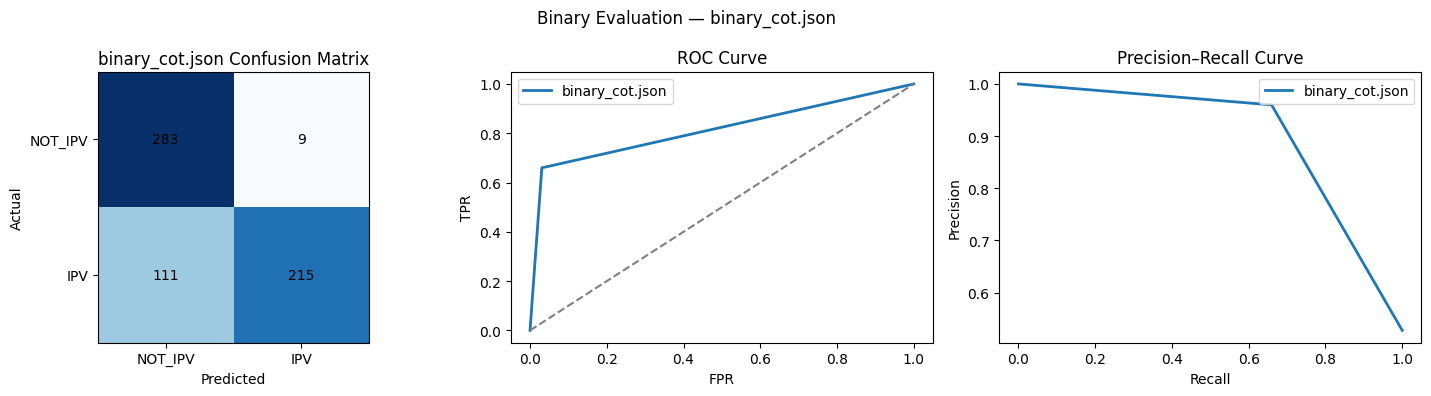


=== Evaluating binary_fewshot.json ===
{'Accuracy': 0.8932038834951457, 'F1': 0.89, 'ROC_AUC': np.float64(0.8975229010841247), 'PR_AUC': np.float64(0.8935638327087934)}


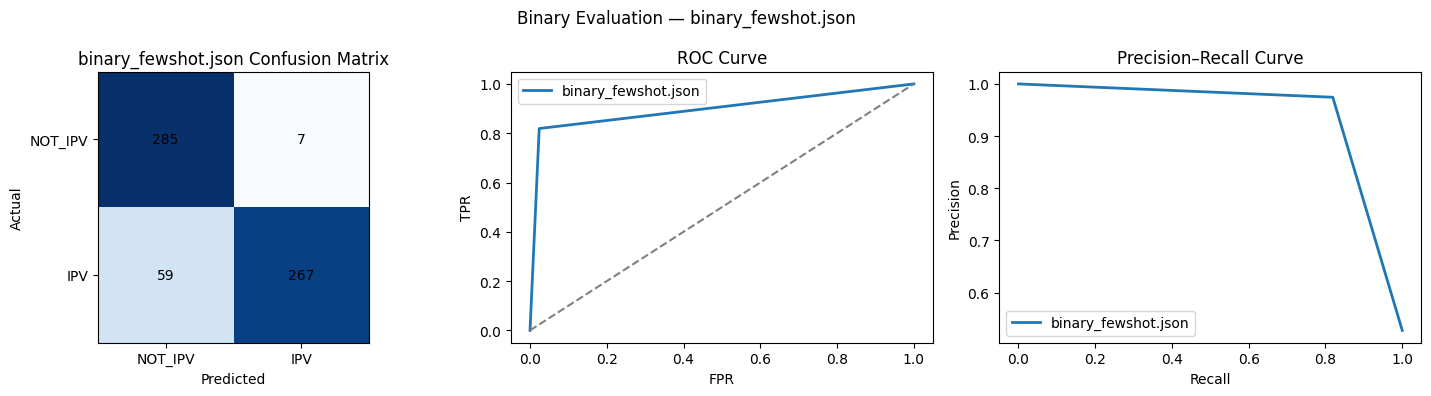


=== Evaluating binary_meta.json ===
{'Accuracy': 0.8527508090614887, 'F1': 0.842832469775475, 'ROC_AUC': np.float64(0.8588221699302463), 'PR_AUC': np.float64(0.8545270599177531)}


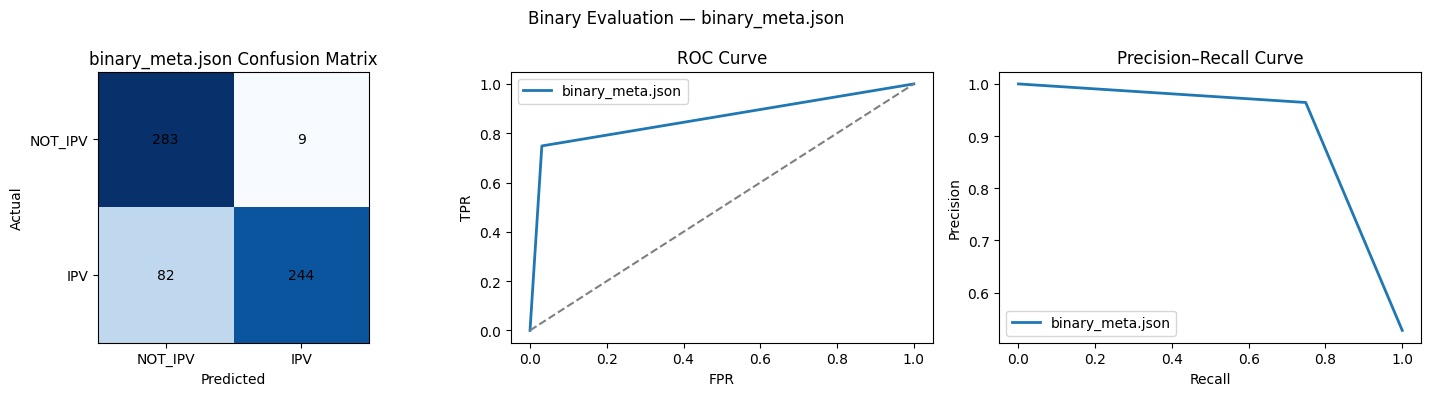


=== Evaluating binary_selfconsistency.json ===
{'Accuracy': 0.8559870550161812, 'F1': 0.846286701208981, 'ROC_AUC': np.float64(0.8620682410286579), 'PR_AUC': np.float64(0.8588377906953475)}


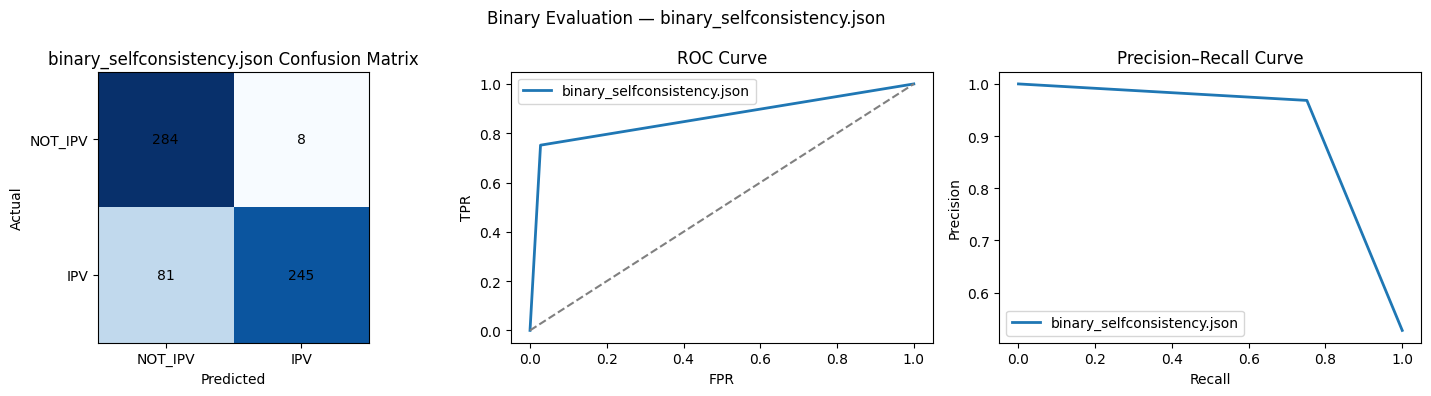


=== Evaluating binary_zeroshot.json ===
{'Accuracy': 0.7281553398058253, 'F1': 0.6557377049180327, 'ROC_AUC': np.float64(0.7419741154718884), 'PR_AUC': np.float64(0.7533467312886377)}


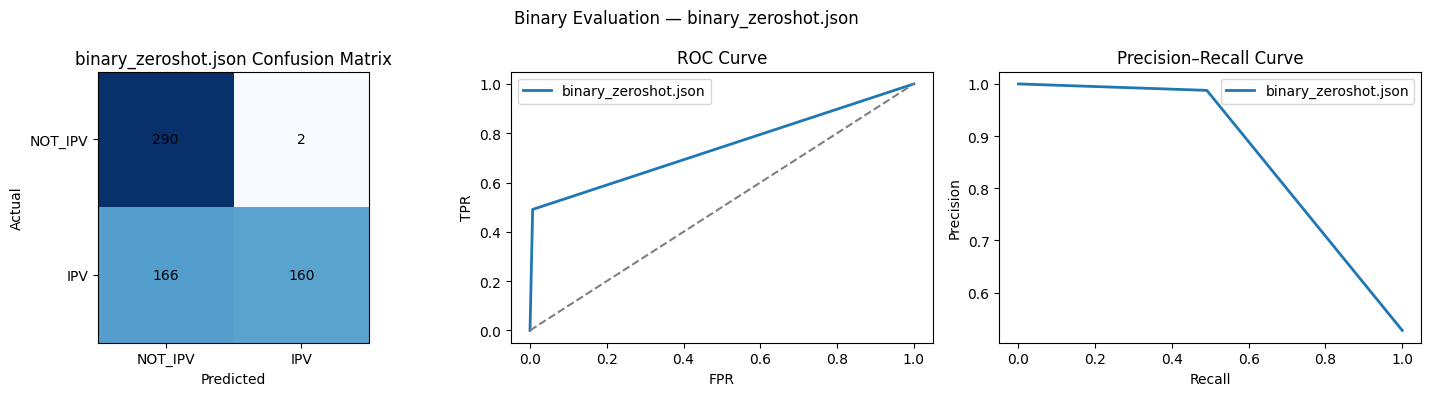



All results saved to: results/binary_results.json


In [23]:
import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

# =====================================
# Paths
# =====================================
GT_PATH = "../Dataset/reddit_data.csv"
RESULTS_DIR = "1_LLM_Eval/test_results_raw/w4"
BINARY_RESULTS_JSON = "results/binary_results.json"

# =====================================
# Helper functions
# =====================================
def compute_binary_metrics_detailed(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
        "ROC_AUC": roc_auc_score(y_true, y_pred),
        "PR_AUC": average_precision_score(y_true, y_pred)
    }

def append_binary_results_to_json(json_path, entry):
    # Load existing or start new
    if Path(json_path).exists():
        with open(json_path, "r") as f:
            data = json.load(f)
    else:
        data = []
    data.append(entry)
    # Save
    with open(json_path, "w") as f:
        json.dump(data, f, indent=2)

def plot_confusion_matrix(y_true, y_pred, ax, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    im = ax.imshow(cm, cmap="Blues")

    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["NOT_IPV","IPV"])
    ax.set_yticklabels(["NOT_IPV","IPV"])

    for (i,j), val in np.ndenumerate(cm):
        ax.text(j, i, val, ha="center", va="center")

def plot_roc_curve_binary(y_true, y_pred, ax, label=""):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    ax.plot(fpr, tpr, lw=2, label=label)
    ax.plot([0,1],[0,1], "--", color="gray")
    ax.set_title("ROC Curve")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend()

def plot_precision_recall_curve_binary(y_true, y_pred, ax, label=""):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    ax.plot(recall, precision, lw=2, label=label)
    ax.set_title("Precision–Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()

# =====================================
# Load ground truth
# =====================================
df_gt = pd.read_csv(GT_PATH)
df_gt["label_true"] = (
    df_gt[["Physical Abuse", "Emotional Abuse", "Sexual Abuse"]].any(axis=1)
).astype(int)
df_gt = df_gt.reset_index().rename(columns={"index": "id"})

# =====================================
# LOOP THROUGH ALL BINARY JSON FILES
# =====================================
binary_files = sorted([f for f in os.listdir(RESULTS_DIR) if f.startswith("binary_") and f.endswith(".json")])
print("Found binary files:", binary_files)

for file in binary_files:
    json_path = os.path.join(RESULTS_DIR, file)
    print(f"\n=== Evaluating {file} ===")

    # Load predictions
    with open(json_path, "r") as f:
        preds = json.load(f)
    df_pred = pd.DataFrame(preds)

    # Ensure id exists
    if "id" not in df_pred:
        df_pred = df_pred.reset_index().rename(columns={"index": "id"})

    # Merge with ground truth
    merged = df_gt.merge(df_pred, on="id", how="inner")

    # Convert LLM output → binary
    merged["y_true"] = merged["label_true"]
    merged["y_pred"] = merged["extracted_label"].str.upper().eq("IPV").astype(int)

    # Compute metrics
    metrics = compute_binary_metrics_detailed(merged["y_true"], merged["y_pred"])
    print(metrics)

    # Save metrics into results JSON
    entry = {
        "file": file,
        "prompt_type": file.replace("binary_","").replace(".json",""),
        "metrics": metrics
    }
    append_binary_results_to_json(BINARY_RESULTS_JSON, entry)

    # ---- Plotting ----
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    plot_confusion_matrix(merged["y_true"], merged["y_pred"], ax=axes[0], title=f"{file} Confusion Matrix")
    plot_roc_curve_binary(merged["y_true"], merged["y_pred"], ax=axes[1], label=file)
    plot_precision_recall_curve_binary(merged["y_true"], merged["y_pred"], ax=axes[2], label=file)

    plt.suptitle(f"Binary Evaluation — {file}")
    plt.tight_layout()
    plt.show()

print("\n\nAll results saved to:", BINARY_RESULTS_JSON)


### 4.3 Multitype Evaluation
Evaluate multitype predictions per subgroup with detailed metrics and visualizations.


In [15]:
# Example: Load multitype predictions and ground truth
# Replace with your actual data loading logic
# This assumes you have:
# - predictions_df: DataFrame with 'id', 'emotional', 'physical', 'sexual' columns
# - ground_truth_df: DataFrame with 'id', 'Physical', 'Emotional', 'Sexual' columns
# - Optional: subgroup column (e.g., 'gender', 'age_group')

# Example setup (modify based on your actual data structure):
MULTITYPE_RESULT_FILE = None  # Set to your multitype result JSON file path
MULTITYPE_PROMPT_TYPE = "zeroshot"  # Set to the prompt type you want to evaluate
MULTITYPE_MODEL_NAME = "qwen2.5-7b"
MULTITYPE_PROMPT_VERSION = MULTITYPE_PROMPT_TYPE

# If you have a result file, load it:
if MULTITYPE_RESULT_FILE and Path(MULTITYPE_RESULT_FILE).exists():
    with open(MULTITYPE_RESULT_FILE, 'r') as f:
        predictions_data = json.load(f)
    predictions_df = pd.DataFrame(predictions_data)

    # Merge with ground truth
    # Assuming df has 'Physical', 'Emotional', 'Sexual' columns (or 'Physical Abuse', etc.)
    merged_df = df.merge(predictions_df, on='id', how='inner')

    # Map column names if needed
    true_cols = []
    pred_cols = []
    for label in ['Physical', 'Emotional', 'Sexual']:
        # Try different possible column names
        true_col = None
        for col in [label, f"{label} Abuse"]:
            if col in merged_df.columns:
                true_col = col
                break
        if true_col:
            true_cols.append(true_col)
            # Prediction columns might be lowercase
            pred_col = label.lower() if label.lower() in merged_df.columns else label
            if pred_col in merged_df.columns:
                pred_cols.append(pred_col)
            else:
                pred_cols.append(None)

    # Filter out None columns
    valid_pairs = [(t, p) for t, p in zip(true_cols, pred_cols) if p is not None]
    if valid_pairs:
        true_cols, pred_cols = zip(*valid_pairs)
        true_cols, pred_cols = list(true_cols), list(pred_cols)

        # Optional: subgroup column (e.g., 'gender', 'age_group')
        subgroup_col = None  # Set to column name if you want per-subgroup metrics

        # Compute multitype metrics per subgroup
        multitype_metrics = compute_multitype_metrics_per_subgroup(
            df=merged_df,
            y_true_cols=true_cols,
            y_pred_cols=pred_cols,
            subgroup_col=subgroup_col
        )

        # Display metrics table
        print("=== Multitype Classification Metrics (Per Subgroup) ===")
        for subgroup, classes in multitype_metrics.items():
            print(f"\n--- Subgroup: {subgroup} ---")
            metrics_list = []
            for class_name, metrics in classes.items():
                row = {'Class': class_name, **metrics}
                metrics_list.append(row)
            metrics_table = pd.DataFrame(metrics_list)
            print(metrics_table.to_string(index=False))

        # Visualizations
        # Get overall metrics for visualization (or first subgroup)
        overall_key = "overall" if "overall" in multitype_metrics else list(multitype_metrics.keys())[0]
        overall_metrics = multitype_metrics[overall_key]

        # Create figure with subplots for confusion matrices
        n_classes = len(overall_metrics)
        fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 5))
        if n_classes == 1:
            axes = [axes]

        # Confusion matrices for each class
        for idx, (class_name, class_metrics) in enumerate(overall_metrics.items()):
            # Get true and predicted for this class
            y_true_class = merged_df[true_cols[idx]].astype(int).values
            y_pred_class = merged_df[pred_cols[idx]].astype(int).values

            plot_confusion_matrix(
                y_true_class, y_pred_class,
                ax=axes[idx],
                title=f"Confusion Matrix - {class_name}",
                xlabel="Predicted",
                ylabel="Actual",
                class_names=["Not Present", "Present"]
            )

        plt.tight_layout()
        plt.show()

        # Per-Class F1 Bar Chart (separate figure)
        fig_f1, ax_f1 = plt.subplots(figsize=(8, 5))
        plot_per_class_f1_bar_chart(
            overall_metrics,
            ax=ax_f1,
            title="Per-Class F1 Scores (Multitype)",
            xlabel="Class",
            ylabel="F1 Score"
        )
        plt.tight_layout()
        plt.show()

        # Append to JSON
        append_multitype_results_to_json(
            json_path=MULTITYPE_JSON_PATH,
            model_name=MULTITYPE_MODEL_NAME,
            prompt_version=MULTITYPE_PROMPT_VERSION,
            metrics_per_subgroup=multitype_metrics,
            notes=f"Evaluation of {MULTITYPE_PROMPT_TYPE} prompt"
        )
        print(f"\nResults appended to {MULTITYPE_JSON_PATH}")
    else:
        print("Could not find matching true/prediction columns. Check column names.")
else:
    print("Set MULTITYPE_RESULT_FILE to a valid path to run multitype evaluation.")


Set MULTITYPE_RESULT_FILE to a valid path to run multitype evaluation.
